## NetOPS_Cadiz

In [90]:
import os
import pandas as pd
import numpy as np
import specdal
import matplotlib.pyplot as plt

class asd():
    def __init__(self, sensores, spec_path, sat):
        self.sensores = sensores
        self.spec_path = spec_path
        self.sats = {  'S2A': ['MSI', 1, 'blue'],'S2B': ['MSI', 2, 'green'],'L8': ['OLI', 3, 'red'],'L9': ['OLI', 4, 'purple'],'L7': ['ETM+', 7, 'orange'],'L5': ['TM', 6, 'brown'], 'L4': ['TM', 5, 'pink']}
        self.sensors = {'MSI': {"B1": [np.arange(412, 457), 443, 'Coastal blue'], "B2": [np.arange(456, 534), 490, 'Blue'], "B3": [np.arange(538, 584), 560, 'Green'], "B4": [np.arange(646, 685), 665, 'Red'], "B5": [np.arange(695, 715), 705, 'Red edge 1'], "B6": [np.arange(731, 760), 740, 'Red edge 2'], "B7": [np.arange(769, 798), 783, 'Red edge 3'], "B8": [np.arange(760, 908), 842, 'Nir'], "B8A": [np.arange(837, 882), 865, 'Nir 8A'], "B9": [np.arange(932, 959), 945, 'Water vapour'], "B10": [np.arange(1337, 1413), 1375, 'Cirrus'], "B11": [np.arange(1539, 1683), 1610, 'Swir 1'], "B12": [np.arange(2078, 2321), 2190, 'Swir 2']},
                        'OLI': {"B1": [np.arange(435, 451), 443, 'Coastal blue'], "B2": [np.arange(452, 512), 482, 'Blue'], "B3": [np.arange(533, 590), 562, 'Green'], "B8": [np.arange(503, 676), 590, 'Pan'], "B4": [np.arange(636, 673), 655, 'Red'], "B5": [np.arange(851, 879), 865, 'Nir'], "B9": [np.arange(1363, 1384), 1374, 'Cirrus'], "B6": [np.arange(1566, 1651), 1609, 'Swir 1'], "B7": [np.arange(2107, 2294), 2200, 'Swir 2']},
                        'ETM+': {"B1": [np.arange(441, 514), 478, 'Blue'], "B2": [np.arange(519, 601), 560, 'Green'], "B3": [np.arange(631, 692), 662, 'Red'], "B4": [np.arange(772, 898), 835, 'Nir'], "B5": [np.arange(1547, 1749), 1648, 'Swir 1'], "B7": [np.arange(2064, 2345), 2205, 'Swir 2']},
                        'TM': {"B1": [np.arange(441, 514), 478, 'Blue'], "B2": [np.arange(519, 601), 560, 'Green'], "B3": [np.arange(631, 692), 662, 'Red'], "B4": [np.arange(772, 898), 835, 'Nir'], "B5": [np.arange(1547, 1749), 1648, 'Swir 1'], "B7": [np.arange(2080, 2345), 2205, 'Swir 2']}}
        
        self.sat = sat
        if sat not in self.sats:
            print('Available satellites at the moment are "S2A", "S2B", "L8", "L9", "L7", L5" and "L4"')

        self.sensor = self.sats[self.sat][0]
        self.sat_data = pd.read_excel(self.sensores, sheet_name=self.sats[self.sat][1]) #Indicamos la hoja del excel sensores en la que está el SRF

    def get_spectros(self, pref=None):
        if not os.path.isdir(self.spec_path):
            raise NotADirectoryError(f"The provided path '{self.spec_path}' is not a directory.")
        specs = [os.path.join(self.spec_path, i.strip(pref)) for i in os.listdir(self.spec_path)]
        return specs 

    def txt2sat(self, spectra, name=None, plot=True, save_csv=False, csv_path=None, print_values=True):
        
        if spectra.endswith('.txt'):
            try:
                datos_ASD = pd.read_csv(spectra, sep="\t", decimal=".", encoding='utf-8', on_bad_lines='skip')
            except UnicodeDecodeError:
                datos_ASD = pd.read_csv(spectra, sep="\t", decimal=".", encoding='latin1', on_bad_lines='skip')
        elif spectra.endswith('.asd'):
            s = specdal.Spectrum(filepath=spectra)
            datos_ASD = s.measurement.to_frame()
            datos_ASD.reset_index(inplace=True)
        else:
            print('Sorry, but right now we can only process ".txt" and ".asd" files')
            return None

        if name:
            datos_ASD.columns = ["Wavelength", name]
        else:
            name = os.path.split(spectra)[1].split('.')[0]
            datos_ASD.columns = ["Wavelength", name]

        datos_ASD = datos_ASD[datos_ASD['Wavelength'] >= 400]

        sat_data_cortados = []
        data_txt_cortados = []

        for banda, rango in self.sensors[self.sensor].items():
            sat_data_cortados.append(self.sat_data[(self.sat_data['SR_WL'] >= min(rango[0])) & (self.sat_data['SR_WL'] <= max(rango[0]))])
            data_txt_cortados.append(datos_ASD[(datos_ASD['Wavelength'] >= min(rango[0])) & (datos_ASD['Wavelength'] <= max(rango[0]))])

        columnas_a_mantener = [[0, i] for i in range(1, len(self.sensors[self.sensor])+1)]

        for i in range(len(self.sensors[self.sensor])):
            sat_data_cortados[i] = sat_data_cortados[i].iloc[:, columnas_a_mantener[i]]

        resultados_media_ponderada_sat = []

        for i in range(len(self.sensors[self.sensor])):
            peso_sat = sat_data_cortados[i].iloc[:, 1]
            datos_txt = data_txt_cortados[i].iloc[:, 1]
            media_ponderada_sat = np.average(datos_txt, weights=peso_sat)
            resultados_media_ponderada_sat.append(media_ponderada_sat)          

        fname = 'MediaPonderada'+self.sat
        datos_sat_pond = pd.DataFrame({fname: resultados_media_ponderada_sat})        
        nombres_filas = [k for k, v in self.sensors[self.sensor].items()]
        datos_sat_pond.index = nombres_filas
        wavelength = [v[1] for k, v in self.sensors[self.sensor].items()]
        datos_sat_pond['Wavelength'] = wavelength

        if print_values:
            print(datos_sat_pond)

        if save_csv and csv_path:
            datos_sat_pond.to_csv(csv_path, index=True)
            print(f'Data saved to {csv_path}')

        if plot:
            plt.figure(figsize=(10, 6))
            plt.plot(datos_ASD['Wavelength'], datos_ASD[name], label=name, color='green')
            plt.ylim(0, 1)
            plt.plot(datos_sat_pond['Wavelength'], datos_sat_pond[fname], label=fname, color='red')
            plt.xlabel('Wavelength (nm)')
            plt.ylabel('Reflectance')
            title = 'Comparación ASD - ' + self.sat
            plt.title(title)
            plt.legend()
            plt.grid(True)
            plt.show()

        return datos_sat_pond  # Return the DataFrame with expected values

    def plot_multiple_spectra(self, spectra_list, names=None, plot_expected=True, sats=None, print_values=False):
            
        if sats is None:
            sats = [self.sat]  # Plot expected data for the satellite specified during initialization by default

        plt.figure(figsize=(10, 6))
        for i, spectra in enumerate(spectra_list):
            name = names[i] if names and i < len(names) else None
            if spectra.endswith('.txt'):
                try:
                    datos_ASD = pd.read_csv(spectra, sep="\t", decimal=".", encoding='utf-8', on_bad_lines='skip')
                except UnicodeDecodeError:
                    datos_ASD = pd.read_csv(spectra, sep="\t", decimal=".", encoding='latin1', on_bad_lines='skip')
                name = os.path.split(spectra)[1].split('.')[0] if not name else name
                plt.plot(datos_ASD['Wavelength'], datos_ASD.iloc[:, 1], label=name)
            elif spectra.endswith('.asd'):
                s = specdal.Spectrum(filepath=spectra)
                datos_ASD = s.measurement.to_frame()
                datos_ASD.reset_index(inplace=True)
                name = os.path.split(spectra)[1].split('.')[0] if not name else name
                plt.plot(datos_ASD.iloc[:, 0], datos_ASD.iloc[:, 1], label=name)
            else:
                print(f'Skipping unsupported file format: {spectra}')
                continue

            if plot_expected:
                for sat in sats:
                    original_sat = self.sat  # Save the original satellite to restore later
                    self.sat = sat  # Temporarily set the satellite
                    self.sensor = self.sats[self.sat][0]
                    self.sat_data = pd.read_excel(self.sensores, sheet_name=self.sats[self.sat][1])

                    expected_data = self.txt2sat(spectra, name=name, plot=False, print_values=print_values)
                    color = self.sats[sat][2]
                    plt.plot(expected_data['Wavelength'], expected_data[f'MediaPonderada{self.sat}'], '--', label=f'Expected {self.sat} - {name}', color=color)
                    self.sat = original_sat  # Restore the original satellite
                    self.sensor = self.sats[self.sat][0]
                    self.sat_data = pd.read_excel(self.sensores, sheet_name=self.sats[self.sat][1])

        plt.xlabel('Wavelength (nm)')
        plt.ylabel('Reflectance')
        plt.title('Comparación de múltiples perfiles espectrales')
        plt.legend()
        plt.grid(True)
        plt.show()
        
    def create_table_for_satellite(self, output_path):
        """
        Genera un archivo CSV con la respuesta de todos los espectros para el satélite especificado.
        """
        if not os.path.isdir(os.path.dirname(output_path)):
            raise NotADirectoryError(f"The directory '{os.path.dirname(output_path)}' does not exist.")

        spectros = self.get_spectros()
        all_data = []

        for spectra in spectros:
            name = os.path.split(spectra)[1].split('.')[0]
            datos_sat_pond = self.txt2sat(spectra, name=name, plot=False, save_csv=False, print_values=False)
            datos_sat_pond = datos_sat_pond.rename(columns={f'MediaPonderada{self.sat}': name})
            all_data.append(datos_sat_pond[name])

        all_data_df = pd.concat(all_data, axis=1)
        all_data_df.to_csv(output_path, index=True)
        print(f'Data saved to {output_path}')

    def create_tables_for_all_spectra(self, output_dir):
        """
        Genera un archivo CSV por cada espectro con los valores de todos los satélites disponibles.
        """
        if not os.path.isdir(output_dir):
            raise NotADirectoryError(f"The provided output directory '{output_dir}' does not exist.")

        spectros = self.get_spectros()
        for spectra in spectros:
            name = os.path.split(spectra)[1].split('.')[0]
            all_sat_data = []

            for sat in self.sats.keys():
                original_sat = self.sat
                self.sat = sat
                self.sensor = self.sats[self.sat][0]
                self.sat_data = pd.read_excel(self.sensores, sheet_name=self.sats[self.sat][1])

                datos_sat_pond = self.txt2sat(spectra, name=name, plot=False, save_csv=False, print_values=False)
                datos_sat_pond = datos_sat_pond.rename(columns={f'MediaPonderada{self.sat}': sat})
                all_sat_data.append(datos_sat_pond[sat])

                self.sat = original_sat
                self.sensor = self.sats[self.sat][0]
                self.sat_data = pd.read_excel(self.sensores, sheet_name=self.sats[self.sat][1])

            all_sat_data_df = pd.concat(all_sat_data, axis=1)
            output_path = os.path.join(output_dir, f'{name}_all_sats.csv')
            all_sat_data_df.to_csv(output_path, index=True)
            print(f'Data saved to {output_path}')



### Define paths to sensors_srf_table (provided with the library), to spectral file and select a satelite to get the spectral response


     MediaPonderadaS2A  Wavelength
B1            0.048094         443
B2            0.052443         490
B3            0.089772         560
B4            0.049386         665
B5            0.172334         705
B6            0.588570         740
B7            0.650709         783
B8            0.653435         842
B8A           0.655640         865
B9            0.653301         945
B10           0.418705        1375
B11           0.361014        1610
B12           0.171078        2190


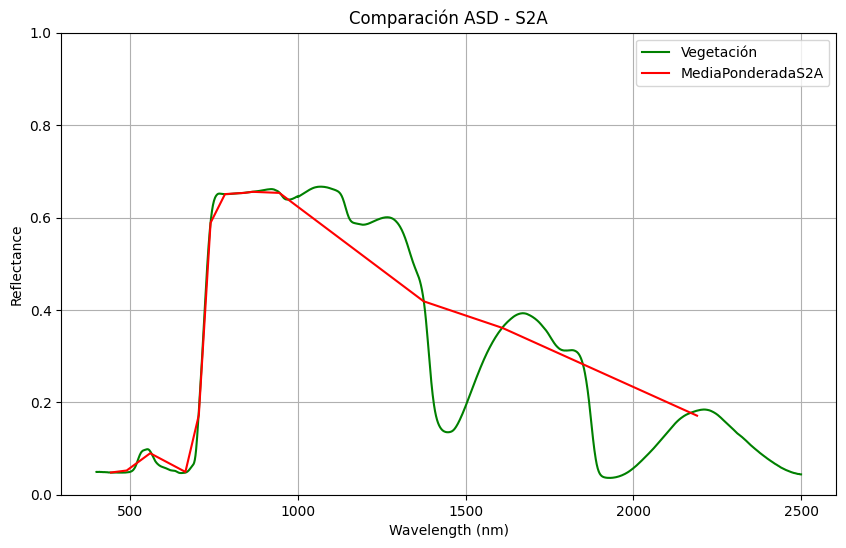

,MediaPonderadaS2A,Wavelength
B1,0.048094,443
B2,0.052443,490
B3,0.089772,560
B4,0.049386,665
B5,0.172334,705
B6,0.588570,740
B7,0.650709,783
B8,0.653435,842
B8A,0.655640,865
B9,0.653301,945


In [91]:
#Paths. Inputs could be both .txt and .asd files
sensores_table = '/path/to/sensores_srs.xlsx' #ruta al xlsx
spec_path_asd = "/path/to/asdfile.asd"
spec_path_txt = "/path/to/txtfile.txt"

#Instance the class with path to sensores_srs table, spec_path amd choose the sat you wanna see
a = asd(sensores_table, spec_path_asd, 'S2A')
a.txt2sat(spec_path_asd, "Vegetación")

### Plot several spectrums and satellite expected bands values together

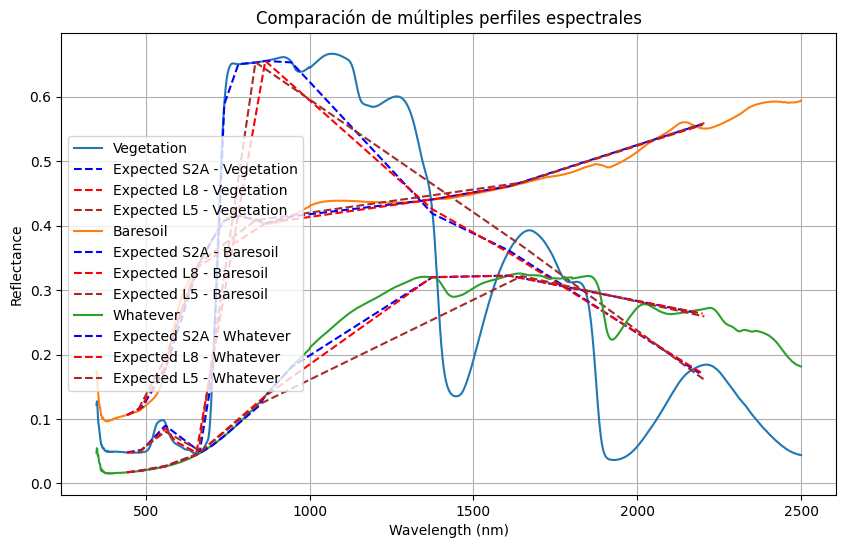

In [93]:
#We can create a spectral list with several spectral to plot all them together in one graphic allongside with the spectral response expected for a list of selected satellites
spec_list_txt = ["path/to/txt1.txt", "path/to/txt2.txt", "path/to/txt3.txt"]

spec_list_asd = ["path/to/asd1.asd", "path/to/asd2.asd", "path/to/asd3.asd"]

#If you want to use this graphic with just one spectrum (maybe you better could use txt2sat) then create a list with just one spectrum
spec_path_asd1l = ["path/to/txt3.txt"]

# Create a list with the satellites you want to see their response allong with the spectrums
sats_to_plot = ["S2A", "L8", "L5"]

# Call the function
a.plot_multiple_spectra(spec_list_asd, names=["Vegetation", "Baresoil", "Whatever"], plot_expected=True, sats=sats_to_plot)

## Export csv files with combination values for all satellites and spectrums

In [75]:
output_dir = "/path/to/output/folder"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

specs_path = "/path/to/Datfolder4/EBD/Cursos/AET_2024_NetOPS/Para_alumnos/Sesion4/4.1.procesado/Datos_TXT/2024_06_04"
# Crear una instancia de la clase asd
a = asd(sensores=sensores_table, spec_path=specs_path, sat="L8")

# Crear una tabla con la respuesta de todos los espectros para el satélite especificado
a.create_table_for_satellite(output_path="/home/diego/Desktop/test/satellite_response2.csv")

# Crear tablas con los valores de todos los satélites para cada espectro
a.create_tables_for_all_spectra(output_dir="/home/diego/Desktop/test")

Data saved to /home/diego/Desktop/test/satellite_response2.csv
Data saved to /home/diego/Desktop/test/curso00000_all_sats.csv
Data saved to /home/diego/Desktop/test/curso00001_all_sats.csv
Data saved to /home/diego/Desktop/test/curso00002_all_sats.csv
Data saved to /home/diego/Desktop/test/curso00003_all_sats.csv
Data saved to /home/diego/Desktop/test/curso00004_all_sats.csv
Data saved to /home/diego/Desktop/test/curso00005_all_sats.csv
Data saved to /home/diego/Desktop/test/curso00006_all_sats.csv
Data saved to /home/diego/Desktop/test/curso00007_all_sats.csv
Data saved to /home/diego/Desktop/test/curso00008_all_sats.csv
Data saved to /home/diego/Desktop/test/curso00009_all_sats.csv
Data saved to /home/diego/Desktop/test/curso00010_all_sats.csv
Data saved to /home/diego/Desktop/test/curso00011_all_sats.csv
Data saved to /home/diego/Desktop/test/curso00012_all_sats.csv
Data saved to /home/diego/Desktop/test/curso00013_all_sats.csv
Data saved to /home/diego/Desktop/test/curso00014_all_s

### That's all for the moment!